In [12]:
#FEWSPI PARSER
# coding: utf-8

# In[1]:

#from pysimplesoap.client import SoapClient
from suds.client import Client
from datetime import datetime
import pytz
import untangle
import pandas as pd
import numpy as np
# import folium
import geopandas as gpd
from geojson import Feature, Point, FeatureCollection
from shapely.geometry import Point
import fire
import random
import json
import os
import tempfile
from xml.etree import ElementTree as et
import gzip


try:
    get_ipython().magic('matplotlib inline')
except:
    a=1


# In[27]:

class fewsPi(object):
    class utils(object):
        def event_client_datetime(event, tz_server, tz_client='Europe/Amsterdam'):
            """
            Get datetime object in client time of an XML Element named event with attributes date and time
            input:
            event     : XML Element named event [eg: obj.TimeSeries.series.event[0]]
            tz_server : datetime abbreviation of the server timezone [eg: 'Etc/GMT']
            tz_client : datetime abbreviation of the client timezone [eg: 'Europe/Amsterdam']

            return
            event_client_time : an datetime object of the event in client timezome

            """    
            # convert XML element date string to integer list
            event_server_date = list(map(int, event['date'].split('-'))) # -> [yyyy, MM, dd]
            event_server_time = list(map(int, event['time'].split(':'))) # -> [HH, mm, ss]

            # define server time
            server_time = datetime(event_server_date[0], event_server_date[1], event_server_date[2], 
                                   event_server_time[0], event_server_time[1], event_server_time[2], 
                                   tzinfo=pytz.timezone(tz_server))    
            client_timezone = pytz.timezone(tz_client)

            # returns datetime in the new timezone
            event_client_time = server_time.astimezone(client_timezone)     

            return event_client_time  

        # function to save xml parsed output as a temporal json file
        def saveJson_tmp(pi_json_object):
            """
            save Fews-Pi json object to temp file

            Parameters
            ----------
            pi_json_object : json object from FEWSPI webservice

            Output
            ----------
            temporary file location
            """
            json_obj = json.loads(pi_json_object)
            json_tmp_file = tempfile.mkstemp(suffix='.json')
            with open(json_tmp_file[1], 'w') as outfile:
                json.dump(json_obj,outfile)
            return json_tmp_file[1]        
    
        # function to save xml parsed output as a temporal json file
        def saveXml_tmp(pi_xml_object):
            """
            save Fews-Pi xml object to temp file

            Parameters
            ----------
            pi_xml_object : xml object from FEWSPI webservice

            Output
            ----------
            temporary file location
            """
            #xml_obj = json.loads(pi_json_object)
            xml_tmp_file = tempfile.mkstemp(suffix='.xml')
            et.ElementTree(et.fromstring(pi_xml_object)).write(open(xml_tmp_file[1], 'w'), encoding='unicode')
            return xml_tmp_file[1]        
        
    
    """class with all fews Pi modules"""            
    def getLocations(self, piService, filterId='f_werk.1', piVersion='1.22', clientId=''):
        """
        This function can get locations from a fews Pi webservice. The following input parameters
        are available:
        
        Parameters
        ----------
        piService : str
            URL to the accessible wsdl FEWS piService (eg. 'http://www.oms-waddenzee.nl:8081/FewsPiService/fewspiservice?wsdl')
        filterId : str 
            standard is 'f_werk.1'
        piVersion : str
            current default is '1.22'
        clientId : str
            current default is ''
        """
        
        # create the service input xml
        #self.getSoapClient(piService=piService)
        self.client = Client(piService)
        getLocations = self.client.factory.create('getLocations')
        
        # check query to execute for pi version
        if piVersion in {'1.22',''}:
            # execute the query
            getLocations_response = self.client.service.getLocations(clientId = clientId, 
                                                                     filterId = filterId, 
                                                                     piVerson = piVersion)
        
            # parse XML object
            obj = untangle.parse_raw(getLocations_response)
            #getLocations_xml_file = fewsPi.utils.saveXml_tmp(getLocations_response)
            #obj = untangle.parse(getLocations_xml_file)

            rows_latlon_list = []
            # get geoDatum
            geoDatum = obj.Locations.geoDatum.cdata
            # get locations
            for location in obj.Locations.location:    
                rows_latlon_list.append({'locationId':location['locationId'],
                                         'shortName':location.shortName.cdata,
                                         'Lat':float(location.lat.cdata),
                                         'Lon':float(location.lon.cdata),
                                         'x':float(location.x.cdata),
                                         'y':float(location.y.cdata)
                                        })

            # CREATE dataframe of location rows dictionary
            df_latlon = pd.DataFrame(rows_latlon_list)

            # CONVERT to geodataframe using latlon for geometry
            geometry = [Point(xy) for xy in zip(df_latlon.Lon, df_latlon.Lat)]
            df = df_latlon.drop(['Lon', 'Lat'], axis=1)
            crs = {'init': 'epsg:4326'}
            gdf2json = gpd.GeoDataFrame(df_latlon, crs=crs, geometry=geometry).to_json()
        return gdf2json
    
    def getTimeZoneId(self, piService):   
        self.client = Client(piService)
        timeZoneId = self.client.service.getTimeZoneId()
        return timeZoneId
    
    def getTimeseries(self, piService, moduleInstanceIds = 'pr.Reizen.vdLee.baggeracties',
                      locationIds = ['bv.1.7.2.1.1','bv.1.7.2.3.2'], parameterIds = 'k.m3.gebaggerd.vdlee',
                      startTime = '2016-08-01T02:00:00.0+02:00', endTime = '2017-02-01T01:00:00.0+01:00',
                      convertDatum = 'false', omitMissing = 'false', onlyHeaders = 'false', 
                      filterId = None, piVersion='1.22', clientId='', zip=False, url=r'http://www.oms-waddenzee.nl/oms.ws/data/'):
        """
        This function can get timeseries from a fews Pi webservice. The following input parameters
        are available:
        
        Parameters
        ----------
        piService : str
            URL to the accessible wsdl FEWS piService (eg. 'http://www.oms-waddenzee.nl:8081/FewsPiService/fewspiservice?wsdl')
        moduleInstanceIds : str
            name of the module used in FEWS (eg. 'pr.Reizen.vdLee.baggeracties')
        locationIds : str or list of strings
            name of the location(s) (eg. ['bv.1.7.2.1.1','bv.1.7.2.3.2'])
        parameterIds : str or list of strings
            name of the parameter(s) (eg. 'k.m3.zandwinning.vdlee')
        startTime : str        
            start time in iso format plus timezone (eg. '2016-08-01T02:00:00.0+02:00')
        endTime : str
            end time in iso format plus timezone (eg. '2017-02-01T02:00:00.0+01:00')
        convertDatum : str (boolean)
            standard is 'false'
        omitMissing : str (boolean)
            standard is 'false'
        onlyHeaders : str (boolean)
            standard is 'false'
        filterId : str 
            standard is None
        piVersion : str
            current default is '1.22'
        clientId : str
            current default is ''            
        """
        
        self.client = Client(piService)
        
        # set timeZoneId
        self.timeZoneId = self.getTimeZoneId(piService)
        
        getTimeSeries = self.client.factory.create('getTimeSeries')

        # check query to execute for pi version
        if piVersion in {'1.22',''}:        
            # fill in the query parameters
            getTimeSeries.queryParams.convertDatum = convertDatum
            getTimeSeries.queryParams.omitMissing = omitMissing
            getTimeSeries.queryParams.onlyHeaders = onlyHeaders
            getTimeSeries.queryParams.moduleInstanceIds = moduleInstanceIds
            
            # fallback if no locations are included, get all locations by request
            if locationIds == '':
                # get the locations as a geojson from the fewspiservice
                piLocations = json.loads(self.getLocations(piService=piService, filterId=filterId, piVersion=piVersion))
                gdf = gpd.GeoDataFrame.from_features(piLocations['features'])
                locationIds = gdf.locationId.tolist()
            getTimeSeries.queryParams.locationIds = locationIds
            
            getTimeSeries.queryParams.parameterIds = parameterIds
            getTimeSeries.queryParams.startTime = startTime#'2016-08-01 02:00'
            getTimeSeries.queryParams.endTime = endTime#'2017-04-01 02:00'
            getTimeSeries.queryParams.version = piVersion

            # execute the query            
            getTimeSeries_response = self.client.service.getTimeSeries(getTimeSeries.queryParams)
            #getTimeSeries_xml_file = fewsPi.utils.saveXml_tmp(getTimeSeries_response)
            
            obj = untangle.parse_raw(getTimeSeries_response)
            #obj = untangle.parse(self.client.service.getTimeSeries(getTimeSeries.queryParams))
            
            # empty dictionary to fill with dictionary format of each row
            # method adopted to avoid appending to pandas dataframe
            event_attributes = ['value','flag']
            rows_ts_dict = {}
            rows_latlon_list = []

            # start iteration
            for series in obj.TimeSeries.series:
                # initiate empty lists
                moduleInstanceId = []
                locationId = []

                stationName= []
                parameterId = []

                event_datetimes = []
                event_values = []
                event_flags = []    

                # collect metadata        
                # GET moduleInstanceId
                try:
                    moduleInstanceId.append(series.header.moduleInstanceId.cdata)
                except AttributeError as e:
                    print ('warning:',e)

                # GET locationId 
                try:
                    locationId.append(series.header.locationId.cdata)
                except AttributeError as e:
                    print ('warning:',e)

                # GET lat
                try:
                    lat = float(series.header.lat.cdata)
                except AttributeError as e:
                    print ('warning:',e)        

                # GET lon
                try:
                    lon = float(series.header.lon.cdata)
                except AttributeError as e:
                    print ('warning:',e)                

                # GET stationNames
                try:
                    stationName.append(series.header.stationName.cdata)
                except AttributeError as e:
                    print ('warning:',e)          

                # GET parameterId    
                try:
                    parameterId.append(series.header.parameterId.cdata + ' (' + series.header.units.cdata + ')')
                except AttributeError as e:
                    print ('warning:',e)

                # GET data values    
                for event in series.event:                    
                    event_datetimes.append( fewsPi.utils.event_client_datetime(event, tz_server='Etc/'+ self.timeZoneId, tz_client='Asia/Yangon'))
                    event_values.append( float(event['value']))
                    event_flags.append( int(event['flag']))

                # PUT timeseries info into row dictionary
                dataValuesFlags = [event_values,event_flags]
                multiColumns = pd.MultiIndex.from_product([moduleInstanceId, parameterId, locationId, stationName, event_attributes], 
                                                          names=['moduleInstanceIds','parameterIds','locationIds','stationName','event_attributes'])
                df_ts_dict = pd.DataFrame(dataValuesFlags,index=multiColumns, columns=event_datetimes).T.to_dict()

                # PUT timeseries row in dictionary of rows
                rows_ts_dict.update(df_ts_dict)

            #     # PUT latlon/location info into row dictionary
            #     df_latlon_dict = pd.DataFrame([{'stationName':stationName[0],'lat':lat,'lon':lon}]).to_dict(orient='split')
            #     print (df_latlon_dict)

                # PUT latlon/location row in dictionary of rows
                rows_latlon_list.append({'stationName':stationName[0],'Lat':lat,'Lon':lon})

            # CREATE dataframe of timeseries rows dictionary
            df_timeseries = pd.DataFrame(rows_ts_dict)

            # reset the multiIndex and create a stacked DataFrame and convert to row-oriented JSON object
            df_timeseries = df_timeseries.stack([0,1,2,3]).rename_axis(['date','moduleId','parameterId','locationId','stationName'])
            df2json = df_timeseries.reset_index().to_json(orient='records', date_format='iso')

          

            
            if zip == True:
                # write to gzip file
                gzfilename = tempfile.mkstemp(suffix='.gz')[1]
                dir_path = os.path.dirname(os.path.realpath('.'))            
                gzfilename = os.path.join(dir_path, '..','data',os.path.split(gzfilename)[1])            
                output = gzip.open(gzfilename, 'wb')
                try:
                    json_str = json.dumps(df2json) 
                    json_bytes = json_str.encode('utf-8')        # 3. bytes (i.e. UTF-8)    
                    output.write(json_bytes)
                finally:
                    output.close() 

                file_out = url+os.path.split(gzfilename)[1]             

            else:
                #json_obj = json.loads(df2json)
                json_file = tempfile.mkstemp(suffix='.json')[1]
                dir_path = os.path.dirname(os.path.realpath('.'))            
                filename = os.path.join(dir_path, '..','data',os.path.split(json_file)[1])                
                
                with open(filename, 'w') as outfile:
                    json.dump(df2json,outfile)
                    
                file_out = url+os.path.split(json_file)[1]
            

            #             # CREATE dataframe of location rows dictionaryD:\My Projects\oms-waddenzee\trunk\src\oms.ws\scripts\fewsPiParser.py
            #             df_latlon = pd.DataFrame(rows_latlon_list)

            #             # CONVERT latitude longitude to geometry points
            #             geometry = [Point(xy) for xy in zip(df_latlon.Lon, df_latlon.Lat)]
            #             df_latlon = df_latlon.drop(['Lon', 'Lat'], axis=1)
            #             crs = {'init': 'epsg:4326'}
            #             gdf_latlon = gpd.GeoDataFrame(df_latlon, crs=crs, geometry=geometry).to_json()

            return file_out

            
    
if __name__ == '__main__':
    try:
        # for command line requests
        fire.Fire(fewsPi)
    except:
        # for jupyter notebooks
        pi = fewsPi()

# test scripts
#>python fewsPiParser.py getTimeseries --piService='http://www.oms-waddenzee.nl:8081/FewsPiService/fewspiservice?wsdl' --locationIds='bv.1.7.2.1.1'
#>python fewsPiParser.py getTimeseries --piService='http://www.oms-waddenzee.nl:8081/FewsPiService/fewspiservice?wsdl' --locationIds=''
#>python fewsPiParser.py getLocations --piService='http://www.oms-waddenzee.nl:8081/FewsPiService/fewspiservice?wsdl' --filterId='f_werk.1'
#>python fewsPiParser.py getTimeZoneId --piService='http://www.oms-waddenzee.nl:8081/FewsPiService/fewspiservice?wsdl'


In [13]:
# get the locations as a geojson from the fewspiservice
_piService = 'http://www.oms-waddenzee.nl:8081/FewsPiService/fewspiservice?wsdl'

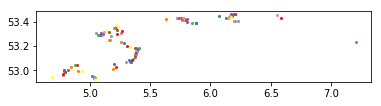

In [14]:
_filterId = 'f_werk'#'f_werk.1' 
_piVersion = '1.22'
piLocations = json.loads(pi.getLocations(piService=_piService, filterId=_filterId, piVersion=_piVersion))
# parse the output to a geodataframe
gdf = gpd.GeoDataFrame.from_features(piLocations['features'])
_locationIds = gdf.locationId.tolist()

gdf.geometry.plot()

In [15]:
_locationIds = ''#gdf.locationId.tolist()
#_locationIds = random.sample(_locationIds, 5)
#_locationIds = #['bv.1.7.2.3.2','bv.1.7.3.1.1']
_startTime = '2016-08-01T02:00:00.0+02:00'
_endTime = '2017-06-16T01:00:00.0+02:00'
_parameterIds = ['k.m3.gebaggerd.vdlee']#,'k.m3.verspreid.vdlee']
_moduleInstanceIds = ['pr.Reizen.vdLee.baggeracties']#,'pr.Reizen.vdLee.verspreidingsacties']
_url = r'D:\jupyter notebooks\3317.20 OMS Waddenzee\tmp'
print (_locationIds)

In [18]:
piTimeseries = pi.getTimeseries(piService=_piService, moduleInstanceIds = _moduleInstanceIds, parameterIds = _parameterIds, locationIds = _locationIds , startTime=_startTime, endTime=_endTime, url=_url )

In [23]:
path = r"D:\data\tmpj1ox1_ja.json"

In [25]:
with open(path) as data_file:    
    stacked = pd.read_json(data_file)

In [37]:
import json

In [ ]:
json.dump()

In [26]:
#stacked = pd.read_json(piTimeseries)
stacked['value'].replace(-999.0,np.NaN, inplace=True)

In [27]:
np.unique(stacked.moduleId), stacked.shape

(array(['pr.Reizen.vdLee.baggeracties'], dtype=object), (32000, 7))

In [28]:
#stacked = stacked[stacked.date >= pd.Timestamp('20170101')] # only from january 1 2017
#stacked = stacked[stacked.date >= pd.Timestamp('20170504')] # only from january 1 2017

In [29]:
#stacked.date = stacked.date.astype(np.int64) // 10**9
#stacked.date = stacked.date.dt.strftime('%Y%m%d')

In [30]:
# webquery for all locations

In [31]:
# webquery for timeseries for selection with 2 locations

In [32]:
# webquery for timeseries for all locations

In [33]:
# VEGA utils
# number of datetime items to display as labels
labelNo = 4

l = stacked.date.tolist()
n = int(len(l) / labelNo)
chunks = [l[i:i + n] for i in range(0, len(l), n)]
date_axes_values = []
for chunk in chunks:    
    date_axes_values.append(chunk[0])#.timestamp()))

In [34]:
# 

# Chart(stacked).mark_text(
#     applyColorToBackground=True
# ).encode(
#     row='stationName',
#     column='date',
#     color='mean(value)',
#     text='mean(value)'
# )

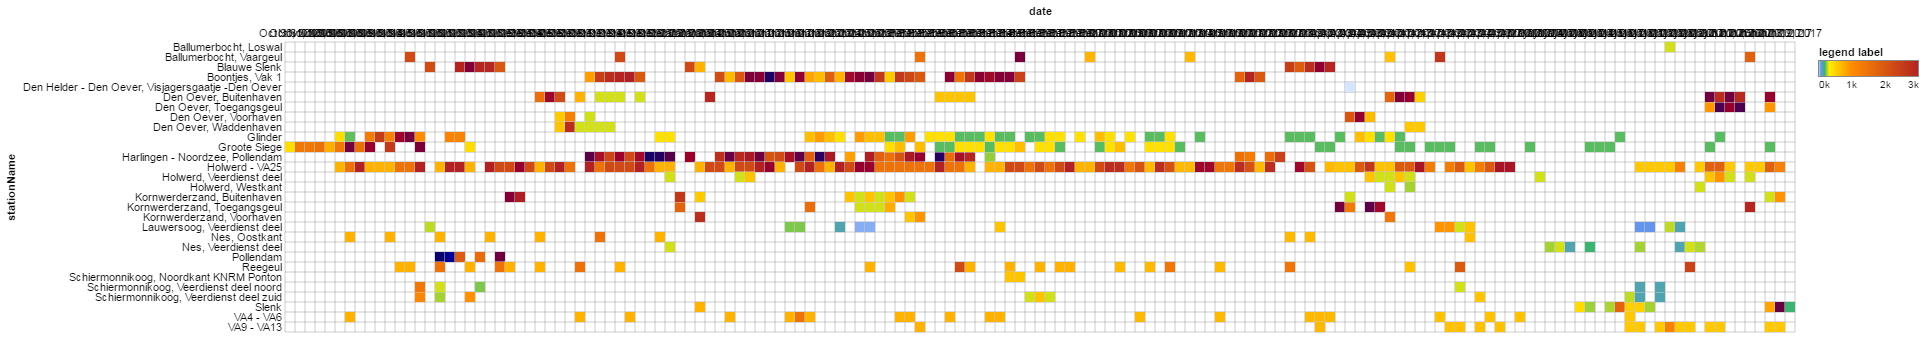

In [35]:
from altair import *
# Define a custom colormape using Hex codes & HTML color names
colormap = Scale(domain=['nan', 0, 100, 200, 350, 1000, 3000],
                 range=['white', '#F0F8FF', 'cornflowerblue',
                        'mediumseagreen', '#FFEE00', 'darkorange', 'firebrick'])

# Define our chart with aesthetic customizations
chart = Chart(stacked).mark_text(
    applyColorToBackground=True,
).encode(
    Column('date'),#,axis=Axis(values=date_axes_values, title=' ')),
    Row('stationName'),# axis=Axis(title='location')),
    Color('sum(value)', scale=colormap,
          legend=Legend(title='legend label',
                        values=[0, 1000, 2000, 3000])),
    Text(value=' ')
).configure_scale(
    textBandWidth=10,
    bandSize=10
)

json = chart.to_dict()

Chart.from_dict(json).display()
#chart2.display()